In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

In [126]:
def soft_threshold(rho, alpha):
    if rho < -alpha:
        return rho + alpha
    elif rho > alpha:
        return rho - alpha
    else:
        return 0

def lasso_fit(X, y, alpha=0.01, max_iter=1000, tol=1e-4):
    n_samples, n_features = X.shape
    beta = np.zeros(n_features)
    diff = float('inf')
    iteration = 0

    while iteration < max_iter and diff > tol:
        beta_prev = np.copy(beta)
        
        for j in range(n_features):
            beta_j = beta[j]
            X_j = X[:, j]
            r_j = y - np.dot(X, beta) + X_j * beta_j
            rho = np.dot(X_j, r_j)
            
            beta[j] = soft_threshold(rho, alpha)  # Update beta without dividing by (np.linalg.norm(X_j)**2 * n_samples)

        diff = np.linalg.norm(beta - beta_prev)
        iteration += 1
    
    return beta

In [148]:
dt = pd.read_csv('ibadan_malaria-prevalence_dataset_1996-2017.csv')
dt1 = dt.drop(['year', 'month', 'nchildren', 'm-age-neg', 'm-age-pos', 'iqr-age-neg', 'iqr-age-pos', 'x-pd', 'sd-pd', 'mmP-rf', 'min-temp', 'max-temp'], axis=1)
dt1.head()

,mm-rf,x-temp,preP
0,2.1,27.745161,0.451613
1,20.9,28.694828,0.465753
2,76.0,28.367903,0.149606
3,140.9,27.763333,0.136126
4,115.1,27.059677,0.309237


In [149]:
dt1 = np.array(dt1)
X = dt1
X[0]

array([ 2.1       , 27.74516129,  0.4516129 ])

In [187]:
dt = 0.001
tmax = 50
t = np.arange(dt, tmax + dt, dt)

In [280]:
# Main Parameters
lambda_val = 17

In [281]:
# Compute dx/dt
dXdt = np.diff(dt1, axis=0) / dt
dXdt = np.vstack((dXdt, dXdt[-1]))

In [282]:
# Compute Theta(X)
x, y, z = dt1[:, 0], dt1[:, 1], dt1[:, 2]
x1, y1, z1 = x, y, z
xy, yz, xz = x * y, y * z, x * z
x2, y2, z2 = x**2, y**2, z**2
x3, y3, z3 = x2 * x, y2 * y, z2 * z
x4, y4, z4 = x3 * x, y3 * y, z3 * z
x5, y5, z5 = x4 * x, y4 * y, z4 * z
cosx, cosy, cosz = np.cos(x), np.cos(y), np.cos(z)
sinx, siny, sinz = np.sin(x), np.sin(y), np.sin(z)
Theta = np.column_stack([np.ones_like(x), x1, y1, z1, xy, yz, xz, x2, y2, z2])
#Theta = np.column_stack([np.ones_like(x), x1, y1, z1, xy, yz, xz, x2, y2, z2, x3, y3, z3,
#                         x4, y4, z4, cosx, cosy, cosz, sinx, siny, sinz])


In [303]:
# LASSO Regression
#Xi = lasso_fit(Theta, dXdt, alpha=0.5, max_iter=10000)
lasso_reg = Lasso(alpha=lambda_val, max_iter=100000)
lasso_reg.fit(Theta, dXdt)
Xi = lasso_reg.coef_

C:\Users\hemay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.564e+11, tolerance: 1.860e+08
  model = cd_fast.enet_coordinate_descent(


In [284]:
# Check the size of Xi
print("Size of Xi:", len(Xi))
print(Xi[2])

Size of Xi: 3
[ 0.00000000e+00 -4.31942462e-01  0.00000000e+00 -0.00000000e+00
  3.66628797e-02 -7.99498980e+00  0.00000000e+00 -1.36491484e-03
  2.87329355e-02 -0.00000000e+00]


In [285]:
malinc=Xi[2]

In [286]:
def mal(r, t, m):
    return malinc[0] + malinc[1]*r + malinc[2]*t + malinc[3]*m + malinc[4]*r*t + malinc[5]*t*m + malinc[6]*r*m + malinc[7]*r**2 + malinc[8]*t**2 + malinc[9]*m**2

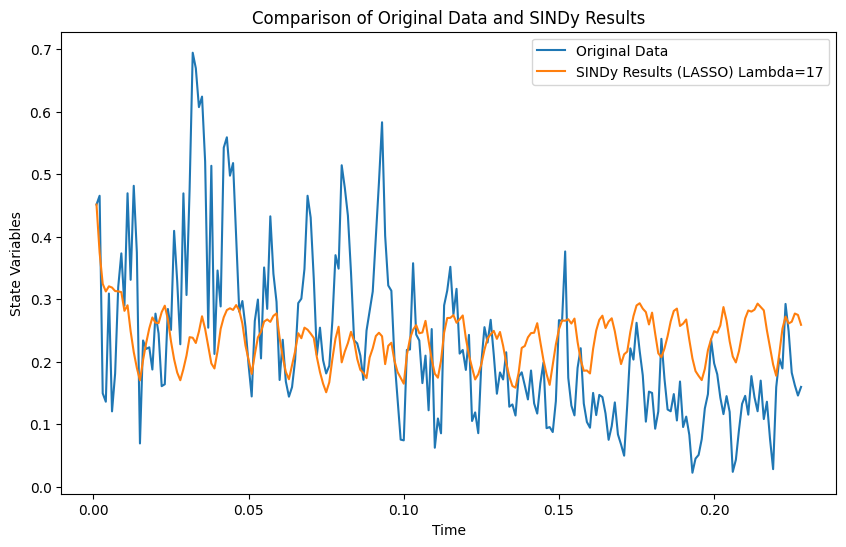

In [287]:
# Initialize X_sindy with the same shape as dt1
X_sindy = np.zeros(228)
# Copy the initial values from dt1
#X_sindy[0] = dt1[0]
x0, y0, z0 = dt1[0,:]
X_sindy[0] = z0

# Simulation loop
for idx in range(1, 228):
    x, y, z = dt1[idx - 1, 0], dt1[idx - 1, 1], X_sindy[idx - 1]
    dzdt_sindy = mal(x, y, z)
    #print(dzdt_sindy)
    X_sindy[idx] = X_sindy[idx - 1] + dt * dzdt_sindy

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t[:len(X_sindy)], dt1[:, 2], label='Original Data')
plt.plot(t[:len(X_sindy)], X_sindy, label='SINDy Results (LASSO) Lambda=17')
plt.title('Comparison of Original Data and SINDy Results')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.show()

C:\Users\hemay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.566e+11, tolerance: 1.860e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\hemay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.065e+08, tolerance: 3.151e+04
  model = cd_fast.enet_coordinate_descent(
C:\Users\hemay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the sca

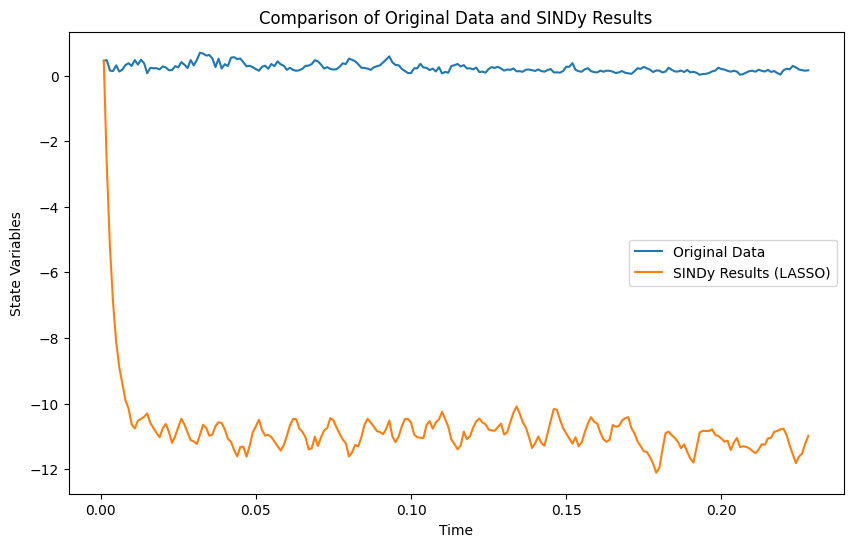

In [311]:
# CUBIOC TERMS
lambda_val = 0.2

# Compute dx/dt
dXdt = np.diff(dt1, axis=0) / dt
dXdt = np.vstack((dXdt, dXdt[-1]))

# Compute Theta(X)
x, y, z = dt1[:, 0], dt1[:, 1], dt1[:, 2]
x1, y1, z1 = x, y, z
xy, yz, xz = x * y, y * z, x * z
x2, y2, z2 = x**2, y**2, z**2
x3, y3, z3 = x2 * x, y2 * y, z2 * z
x4, y4, z4 = x3 * x, y3 * y, z3 * z
x5, y5, z5 = x4 * x, y4 * y, z4 * z
cosx, cosy, cosz = np.cos(x), np.cos(y), np.cos(z)
sinx, siny, sinz = np.sin(x), np.sin(y), np.sin(z)
#Theta = np.column_stack([np.ones_like(x), x1, y1, z1, xy, yz, xz, x2, y2, z2])
Theta = np.column_stack([np.ones_like(x), x1, y1, z1, xy, yz, xz, x2, y2, z2, x3, y3, z3,
                         x4, y4, z4, cosx, cosy, cosz])

# LASSO Regression
#Xi = lasso_fit(Theta, dXdt, alpha=0.5, max_iter=10000)
lasso_reg = Lasso(alpha=lambda_val, max_iter=100000)
lasso_reg.fit(Theta, dXdt)
Xi = lasso_reg.coef_

malinc=Xi[2]

# Initialize X_sindy with the same shape as dt1
X_sindy = np.zeros(228)
# Copy the initial values from dt1
#X_sindy[0] = dt1[0]
x0, y0, z0 = dt1[0,:]
X_sindy[0] = z0

# Simulation loop
for idx in range(1, 228):
    x, y, z = dt1[idx - 1, 0], dt1[idx - 1, 1], X_sindy[idx - 1]
    dzdt_sindy = mal(x, y, z)
    #print(dzdt_sindy)
    X_sindy[idx] = X_sindy[idx - 1] + dt * dzdt_sindy

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t[:len(X_sindy)], dt1[:, 2], label='Original Data')
plt.plot(t[:len(X_sindy)], X_sindy, label='SINDy Results (LASSO)')
plt.title('Comparison of Original Data and SINDy Results')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.show()

C:\Users\hemay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.578e+11, tolerance: 1.860e+08
  model = cd_fast.enet_coordinate_descent(
C:\Users\hemay\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.069e+08, tolerance: 3.151e+04
  model = cd_fast.enet_coordinate_descent(


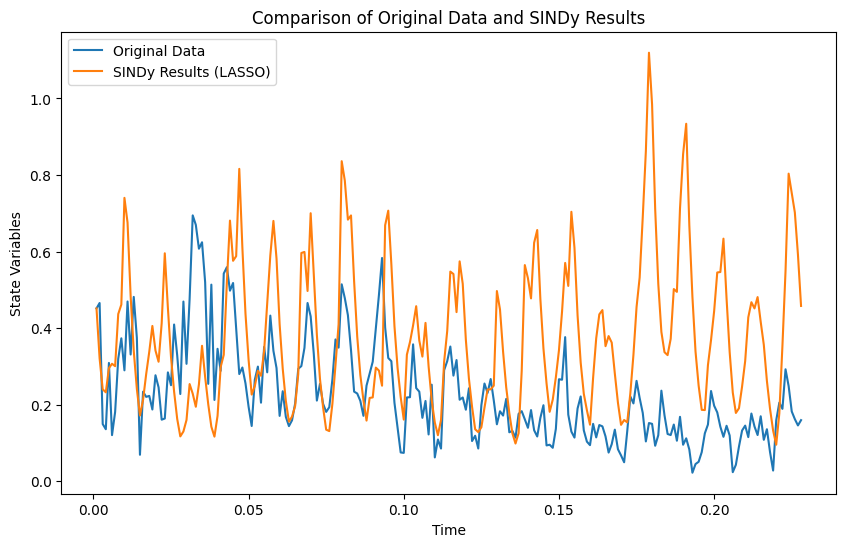

In [322]:
# CUBIOC TERMS
lambda_val = 2

# Compute dx/dt
dXdt = np.diff(dt1, axis=0) / dt
dXdt = np.vstack((dXdt, dXdt[-1]))

# Compute Theta(X)
x, y, z = dt1[:, 0], dt1[:, 1], dt1[:, 2]
x1, y1, z1 = x, y, z
xy, yz, xz = x * y, y * z, x * z
x2, y2, z2 = x**2, y**2, z**2
x3, y3, z3 = x2 * x, y2 * y, z2 * z
x4, y4, z4 = x3 * x, y3 * y, z3 * z
x5, y5, z5 = x4 * x, y4 * y, z4 * z
cosx, cosy, cosz = np.cos(x), np.cos(y), np.cos(z)
sinx, siny, sinz = np.sin(x), np.sin(y), np.sin(z)
#Theta = np.column_stack([np.ones_like(x), x1, y1, z1, xy, yz, xz, x2, y2, z2])
Theta = np.column_stack([np.ones_like(x), x1, y1, z1, xy, yz, xz, x2, y2, z2, x3, y3, z3,
                         x4, y4, z4, cosx, cosy, cosz])

# LASSO Regression
#Xi = lasso_fit(Theta, dXdt, alpha=0.5, max_iter=10000)
lasso_reg = Lasso(alpha=lambda_val, max_iter=100000)
lasso_reg.fit(Theta, dXdt)
Xi = lasso_reg.coef_

malinc=Xi[2]

# Initialize X_sindy with the same shape as dt1
X_sindy = np.zeros(228)
# Copy the initial values from dt1
#X_sindy[0] = dt1[0]
x0, y0, z0 = dt1[0,:]
X_sindy[0] = z0

# Simulation loop
for idx in range(1, 228):
    x, y, z = dt1[idx - 1, 0], dt1[idx - 1, 1], X_sindy[idx - 1]
    dzdt_sindy = mal(x, y, z)
    #print(dzdt_sindy)
    X_sindy[idx] = X_sindy[idx - 1] + dt * dzdt_sindy

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t[:len(X_sindy)], dt1[:, 2], label='Original Data')
plt.plot(t[:len(X_sindy)], X_sindy, label='SINDy Results (LASSO)')
plt.title('Comparison of Original Data and SINDy Results')
plt.xlabel('Time')
plt.ylabel('State Variables')
plt.legend()
plt.show()